### Tarea 1: Inteligencia artificial 
### Sergio Alberto De León Martínez 

Para experimentar con las diferentes configuraciones, voy a usar el dataset de dígitos escritos a mano MNIST

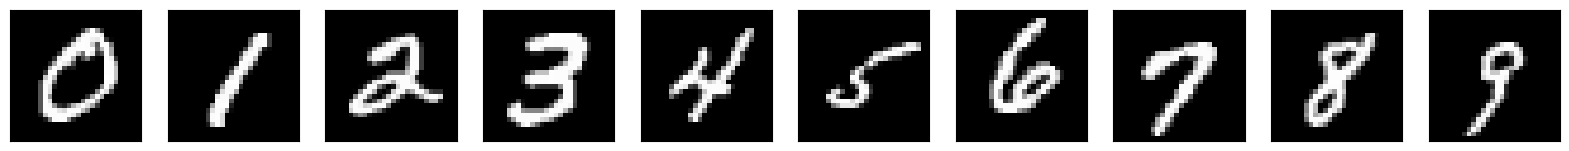

In [1]:
# Experiments with dataset MNIST
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

mnist_dataset = datasets.MNIST(root='dataset/', train=True, download=True)

# Extract a sample 
sample_images = []
digit = 0
for image, label in mnist_dataset:
    if label == digit:
        sample_images.append(np.array(image))
        digit += 1
# Plot the numbers 
plt.figure(figsize=(20, 4))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    plt.imshow(sample_images[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

A continuación muestro la imagen que quiero reconstruir, esta imagen es de un solo canal en escala de grises de 256x256 pixeles 

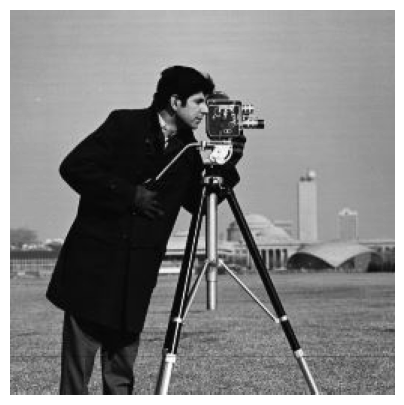

In [2]:
# Leer la imagen 
import requests

url = 'https://www.math.hkust.edu.hk/~masyleung/Teaching/CAS/MATLAB/image/images/cameraman.jpg'
response = requests.get(url)

if response.status_code == 200:
    with open('cameramen.jpg', 'wb') as file:
        file.write(response.content)

# Mostramos la imagen 
from PIL import Image

image = Image.open('cameramen.jpg')
ax = plt.figure(figsize=(5, 5))
image = image.convert('L')
cameraman = np.array(image)
plt.gray()
plt.imshow(image)
plt.axis('off')
plt.show()

A continuación implementamos una función para calcular la pseudoinversa de Moore-Penrose y para calcular el error cuadráticoo medio 

In [57]:
# Moore Penrose pseudoinverse
def moore_penrose(X_train, y_train, lambda_reg=1e-6, regularization=False):
    I = np.identity(X_train.shape[1]) 
    if regularization:
        aux_matrix = (X_train.T @ X_train) + lambda_reg * I  # Adding regularization term
    else:
        aux_matrix = (X_train.T @ X_train)
    aux_vector = X_train.T @ y_train
    w = np.linalg.solve(aux_matrix, aux_vector)  
    return w
# Mean Square Error 
def MSE(real_image, reconstructed_image):
    return ((np.linalg.norm(real_image.reshape(-1) - reconstructed_image.reshape(-1)))**2) / (real_image.shape[0] * real_image.shape[1])

El siguiente bloque de código es el cuerpo principal de la implementación, en el se despliega el forward pass, el backward y el descenso del gradiente, tanto para funciones multicuádricas como gaussianas.

In [64]:
def NN_RBF(n_units, epochs, kappa, lr, image, fnc_radial, optimizer, save_image=False, display_image=False):
  # Initialize parameters 
  image = image
  flat_image = image.reshape(-1)
  hight, width = image.shape[0], image.shape[1]
  n_pixels = width * hight
  parameters_theta = np.random.uniform(1, width, (n_units, 2))
  parameters_alpha = np.random.uniform(0, 1, (n_units, 1))
  grad_theta = np.zeros((n_units, 2))
  Phi_matrix = np.zeros((n_pixels, n_units))
  momentum = 0.99
  decay_rate = 0.99
  velocity = np.random.uniform(0, 0, (n_units, 2))
  accumulation_var = np.random.uniform(0, 0, (n_units, 2))

  def forward(fnc_radial, Phi_matrix, kappa, parameters_theta):
    coordinates = np.array([[i // width, i % width] for i in range(n_pixels)])
    for j in range(n_units):
      # Compute the distance from each pixel to the center of unit j
      dist = np.linalg.norm(coordinates - parameters_theta[j], axis=1)
      if fnc_radial == 'multiquadric':
        Phi_matrix[:, j] = np.sqrt(dist**2 + kappa**2)
      elif fnc_radial == 'gaussian':
        Phi_matrix[:, j] = np.exp(-kappa * (dist ** 2))

  def reconstruct_image(Phi_matrix, parameters_alpha):
    reconstructed_image = Phi_matrix @ parameters_alpha
    return reconstructed_image.reshape(image.shape[0], image.shape[1])

  def backward(fnc_radial, Phi_matrix, grad_theta, parameters_theta, kappa):
    coordinates = np.array([[i // width, i % width] for i in range(n_pixels)])
    for l in range(n_units):
      for k in range(2):
        if fnc_radial == 'multiquadric': 
          grad_theta[l, k] = (-2 * parameters_alpha[l]) * sum(
            (flat_image - Phi_matrix @ parameters_alpha) * (parameters_theta[l, k] - coordinates[:, k]) / Phi_matrix[:, l]
          )
        elif fnc_radial == 'gaussian':  
          grad_theta[l, k] = (4 * kappa * parameters_alpha[l]) * sum(
            (flat_image - Phi_matrix @ parameters_alpha) * Phi_matrix[:, l] * (parameters_theta[l, k] - coordinates[:, k])
          )

  def GD(parameters_theta, grad_theta, lr, fnc_radial, Phi_matrix, kappa):
    backward(fnc_radial, Phi_matrix, grad_theta, parameters_theta, kappa) # updates grads  
    parameters_theta = parameters_theta - lr * grad_theta # grad descent step, updates theta's 

  def GDNesterov(parameters_theta, grad_theta, lr, momentum, velocity, fnc_radial, Phi_matrix, kappa):
    parameters_theta = parameters_theta + momentum * velocity # interim update
    forward(fnc_radial, Phi_matrix, kappa, parameters_theta)
    backward(fnc_radial, Phi_matrix, grad_theta, parameters_theta, kappa) # compute gradient at interm point
    velocity = momentum * velocity - lr * grad_theta # update velocity 
    parameters_theta = parameters_theta + velocity # update thetas 
  
  def ADAM(parameters_theta, grad_theta, lr, momentum, velocity, accumulation_var, fnc_radial, Phi_matrix, kappa, decay_rate):
    parameters_theta = parameters_theta + momentum * velocity # interim update
    forward(fnc_radial, Phi_matrix, kappa, parameters_theta)
    backward(fnc_radial, Phi_matrix, grad_theta, parameters_theta, kappa) # compute gradient at interim point
    accumulation_var = decay_rate * accumulation_var + (1 - decay_rate) * (grad_theta * grad_theta) # accumulate gradient
    velocity = momentum * velocity - lr * (grad_theta / np.sqrt(accumulation_var))
    parameters_theta = parameters_theta + velocity

  # Train 
  for epoch in range(epochs):
    # forward 
    forward(fnc_radial, Phi_matrix, kappa, parameters_theta)
    # update alpha's 
    parameters_alpha = moore_penrose(Phi_matrix, flat_image)
    if optimizer == 'gradient_descent':
      GD(parameters_theta, grad_theta, lr, fnc_radial, Phi_matrix, kappa)
    elif optimizer == 'nesterov':
      GDNesterov(parameters_theta, grad_theta, lr, momentum, velocity, fnc_radial, Phi_matrix, kappa)
    elif optimizer == 'adam':
      ADAM(parameters_theta, grad_theta, lr, momentum, velocity, accumulation_var, fnc_radial, Phi_matrix, kappa, decay_rate)
    # print(f'Epoch {epoch+1}/{epochs}')
  
  reconstructed_image = reconstruct_image(Phi_matrix, parameters_alpha)

  if display_image:  
    # Display reconstructed image 
    plt.figure(figsize=(3, 3))
    plt.imshow(reconstructed_image)
    plt.gray()
    plt.axis('off')
    plt.title('Reconstructed image')
    if save_image:
      plt.savefig('reconstructed_image.jpg')
    plt.show()
  return reconstructed_image


A continuación hacemos una serie de experimentos con el dataset MNIST, esto con la finalidad de probar diferentes configuraciones y determinar cuál presenta un mejor rendimiento.

Error promedio de reconstrucción: 337.4199799590774


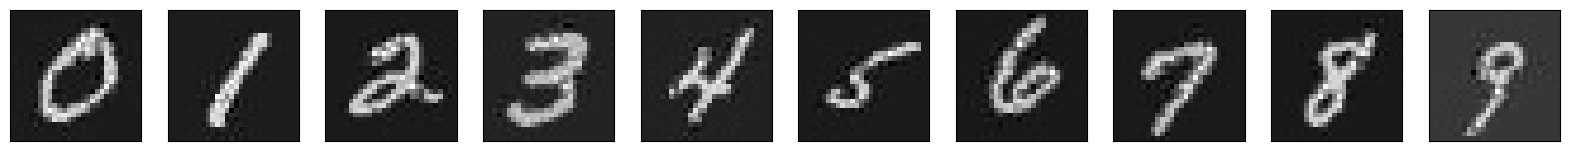

In [77]:
# Gaussian, stochastic 
# Configuration 
n_units = 500
epochs = 3
kappa = 1
lr = 1e-3
fnc_radial = 'gaussian'
optimizer = 'stochastic'
# Reconstruct images 
reconstructed_images = []
for image in sample_images:
    reconstructed_image = NN_RBF(n_units, epochs, kappa, lr, image, fnc_radial, optimizer)
    reconstructed_images.append(reconstructed_image)
# Reconstruction error
mse = 0
for i in range(10):
    mse += MSE(sample_images[i], reconstructed_images[i])
print('Error promedio de reconstrucción:', mse / 10)
# Display reconstructed images 
plt.figure(figsize=(20, 4))
plt.tight_layout()
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    plt.imshow(reconstructed_images[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Error promedio de reconstrucción: 94.20799395199865


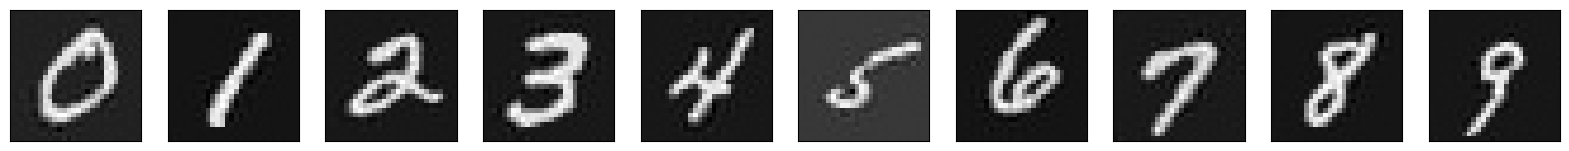

In [76]:
# Multiquadric, stochastic 
# Configuration 
n_units = 500
epochs = 3
kappa = 1
lr = 1e-3
fnc_radial = 'multiquadric'
optimizer = 'stochastic'
# Reconstruct images 
reconstructed_images = []
for image in sample_images:
    reconstructed_image = NN_RBF(n_units, epochs, kappa, lr, image, fnc_radial, optimizer)
    reconstructed_images.append(reconstructed_image)
# Reconstruction error
mse = 0
for i in range(10):
    mse += MSE(sample_images[i], reconstructed_images[i])
print('Error promedio de reconstrucción:', mse / 10)
# Display reconstructed images 
plt.figure(figsize=(20, 4))
plt.tight_layout()
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    plt.imshow(reconstructed_images[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Error promedio de reconstrucción: 365.1968914748101


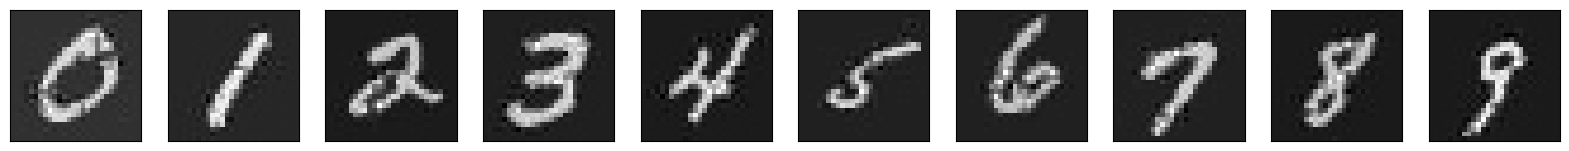

In [78]:
# Gaussian, nesterov
# Configuration 
n_units = 500
epochs = 3
kappa = 1
lr = 1e-3
fnc_radial = 'gaussian'
optimizer = 'nesterov'
# Reconstruct images 
reconstructed_images = []
for image in sample_images:
    reconstructed_image = NN_RBF(n_units, epochs, kappa, lr, image, fnc_radial, optimizer)
    reconstructed_images.append(reconstructed_image)
# Reconstruction error
mse = 0
for i in range(10):
    mse += MSE(sample_images[i], reconstructed_images[i])
print('Error promedio de reconstrucción:', mse / 10)
# Display reconstructed images 
plt.figure(figsize=(20, 4))
plt.tight_layout()
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    plt.imshow(reconstructed_images[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Error promedio de reconstrucción: 89.87831553439302


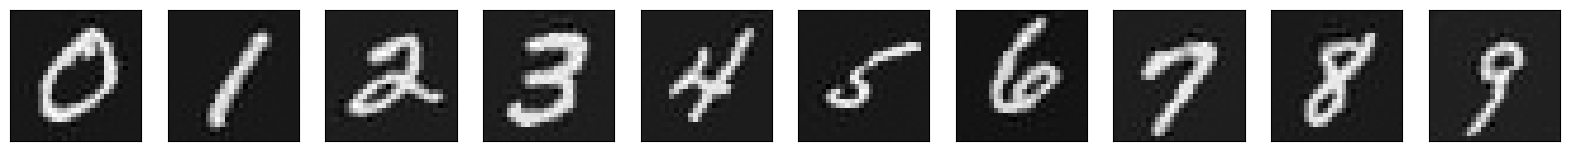

In [79]:
# Multiquadric, nesterov 
# Configuration 
n_units = 500
epochs = 3
kappa = 1
lr = 1e-3
fnc_radial = 'multiquadric'
optimizer = 'nesterov'
# Reconstruct images 
reconstructed_images = []
for image in sample_images:
    reconstructed_image = NN_RBF(n_units, epochs, kappa, lr, image, fnc_radial, optimizer)
    reconstructed_images.append(reconstructed_image)
# Reconstruction error
mse = 0
for i in range(10):
    mse += MSE(sample_images[i], reconstructed_images[i])
print('Error promedio de reconstrucción:', mse / 10)
# Display reconstructed images 
plt.figure(figsize=(20, 4))
plt.tight_layout()
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    plt.imshow(reconstructed_images[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Error promedio de reconstrucción: 436.11199426424565


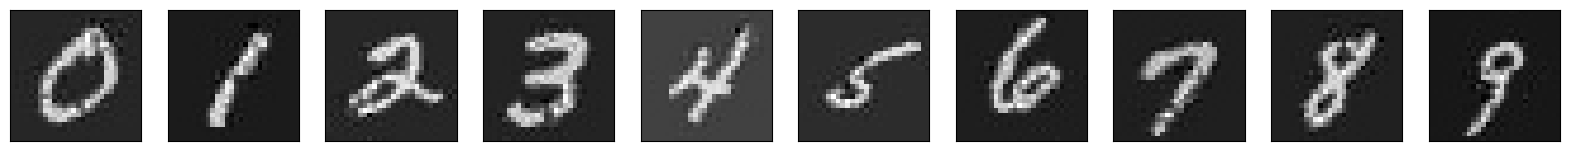

In [80]:
# Gaussian, adam 
# Configuration 
n_units = 500
epochs = 3
kappa = 1
lr = 1e-3
fnc_radial = 'gaussian'
optimizer = 'adam'
# Reconstruct images 
reconstructed_images = []
for image in sample_images:
    reconstructed_image = NN_RBF(n_units, epochs, kappa, lr, image, fnc_radial, optimizer)
    reconstructed_images.append(reconstructed_image)
# Reconstruction error
mse = 0
for i in range(10):
    mse += MSE(sample_images[i], reconstructed_images[i])
print('Error promedio de reconstrucción:', mse / 10)
# Display reconstructed images 
plt.figure(figsize=(20, 4))
plt.tight_layout()
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    plt.imshow(reconstructed_images[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Error promedio de reconstrucción: 92.74357594378401


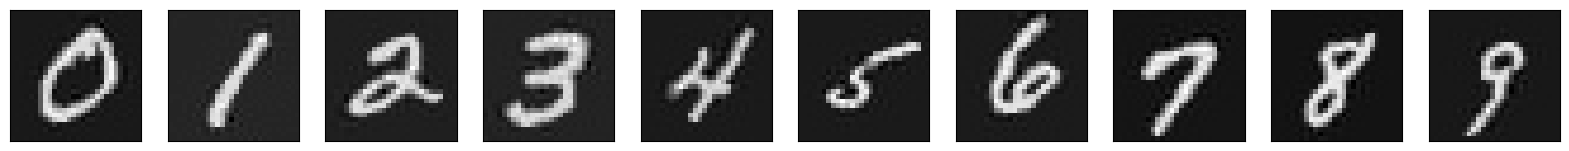

In [81]:
# Multiquadric, adam 
# Configuration 
n_units = 500
epochs = 3
kappa = 1
lr = 1e-3
fnc_radial = 'multiquadric'
optimizer = 'adam'
# Reconstruct images 
reconstructed_images = []
for image in sample_images:
    reconstructed_image = NN_RBF(n_units, epochs, kappa, lr, image, fnc_radial, optimizer)
    reconstructed_images.append(reconstructed_image)
# Reconstruction error
mse = 0
for i in range(10):
    mse += MSE(sample_images[i], reconstructed_images[i])
print('Error promedio de reconstrucción:', mse / 10)
# Display reconstructed images 
plt.figure(figsize=(20, 4))
plt.tight_layout()
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    plt.imshow(reconstructed_images[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Finalmente para reconstruir la imagen objetivo optamos por usar unidades gaussianas y optimizador ADAM.

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


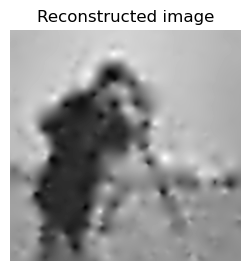

In [49]:
# Gaussian, adam, REAL image
# Configuration 
n_units = 500
epochs = 10
kappa = 1
lr = 1e-3
image = cameraman # REAL image
fnc_radial = 'multiquadric'
optimizer = 'adam'

reconstructed_image = NN_RBF(n_units, epochs, kappa, lr, image, fnc_radial, optimizer, save_image=True)

In [58]:
# Reconstructed error
error = MSE(cameraman, reconstructed_image)
print('Error de reconstrucción', error)

Error de reconstrucción 809.699716400796
